In [1]:
#Homework 1 Problem 2
#Nathan Taylor
#01/25/22

a) In  a single error fragile gate sequence, if one or more errors occur, the result is effectively random. With such an L qubit cluster, if an error occurs, there is a (1/2)^L probability to return to the initial state.

In [2]:
#b) Random Quantum Circuit (RQC)
import cirq
import random
import matplotlib.pyplot as plt
import numpy as np
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

In [3]:
def twoqubit(q):
    forward = []
    reverse = []
    a = cirq.Moment(cirq.ISWAP(q[0],q[1]),cirq.ISWAP(q[2],q[3]))
    b = cirq.Moment(cirq.ISWAP(q[1],q[2]),cirq.ISWAP(q[3],q[4]))
    c = cirq.Moment(cirq.Z(q[0]),cirq.Z(q[2]))
    d = cirq.Moment(cirq.Z(q[1]),cirq.Z(q[3]))
    e = cirq.Moment(cirq.Z(q[0]),cirq.Z(q[2]),cirq.Z(q[1]),cirq.Z(q[3]))
    forward.append(a)
    forward.append(b)
    #Mirror Stuff
    reverse.append(c)#1st Z sandwhich
    reverse.append(a)#iSWAPs
    reverse.append(e)#Z sandwhich
    reverse.append(b)#iSWAPS
    reverse.append(d)#last Z sandwhich
    return (forward, reverse)

def randrotation(line):
    forward = []
    reverse = []
    rot_gates = [cirq.rx,cirq.ry,cirq.rz]
    for q in line:
        gate = random.randint(0,2)
        angle = random.uniform(0,1)
        forward.append(rot_gates[gate](np.pi*angle)(q))#apply X Y or Z rotation with any angle 0->pi
        reverse.append(rot_gates[gate](np.pi*angle*-1)(q))
    return (cirq.Moment(forward), cirq.Moment(reverse))

def makeRQC(line):
    ops = cirq.Circuit()
    mirror = cirq.Circuit()

    #Superposition
    for q in line:
        ops.append(cirq.H(q))
        mirror.append(cirq.H(q))

    #RQC Layers
    for i in range(3):
        on, off = twoqubit(line)
        ops.append(on)
        mirror.append(off)
        rot, unrot = randrotation(line)
        ops.append(rot)
        mirror.append(unrot)

    #Add Reflection:
    for x in range(len(mirror)):
        ops.append(mirror[len(mirror)-x-1])
    
    return ops

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


measurements: (no measurements)
output vector: |00000⟩


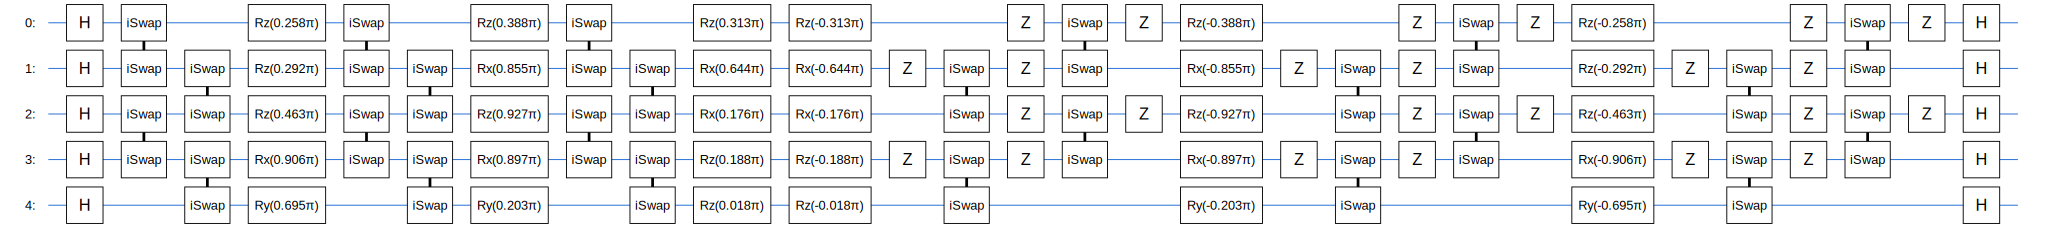

In [4]:
#c) 
#Perfect Execution Simulation
qubits = cirq.LineQubit.range(5)
circuit = makeRQC(qubits)

counts = 1000
sim = cirq.Simulator()
samples = sim.simulate(circuit)
print(samples)

SVGCircuit(circuit)

In [5]:
#Single Error Implantation
def single_error(line):
    ops = makeRQC(line)
    err_layer = random.randint(0,len(ops)-1)#choose layer
    err_qubit = random.randint(0, len(line)-1)#choose qubit
    
    single = cirq.Circuit()
    single.append(ops[0:err_layer])#split circuit at error layer
    single.append(cirq.X(line[err_qubit]))#add error
    single.append(ops[err_layer:len(ops)-1])
    single.append(cirq.measure(*line,key='z'))
    return single

In [6]:
states_recovered = 0
loops = 1000

for i in range(loops):
    qbits = cirq.LineQubit.range(5)#Initialize
    echo = single_error(qbits)#Build Circuit
    out_state = sim.run(echo)#Run it once
    a = str(out_state)#Parse Output
    b=a.split(", ")
    b[0]=b[0][2]
    c=""
    for q in b:
        c+=q
    if c == "00000":
        states_recovered += 1

print("Average Fidelity: ", states_recovered/loops)

Average Fidelity:  0.028


In [7]:
#Expected Fidelity
print("Expected Fidelity: ", (1/2)**5)

Expected Fidelity:  0.03125


The result from a) is validated